# Neural Style Transfer

This tutorial takes two images as input:
- content image
- style image

We then wish to create a mixed image which has the contours of the content image and the colors and texture of the style image.

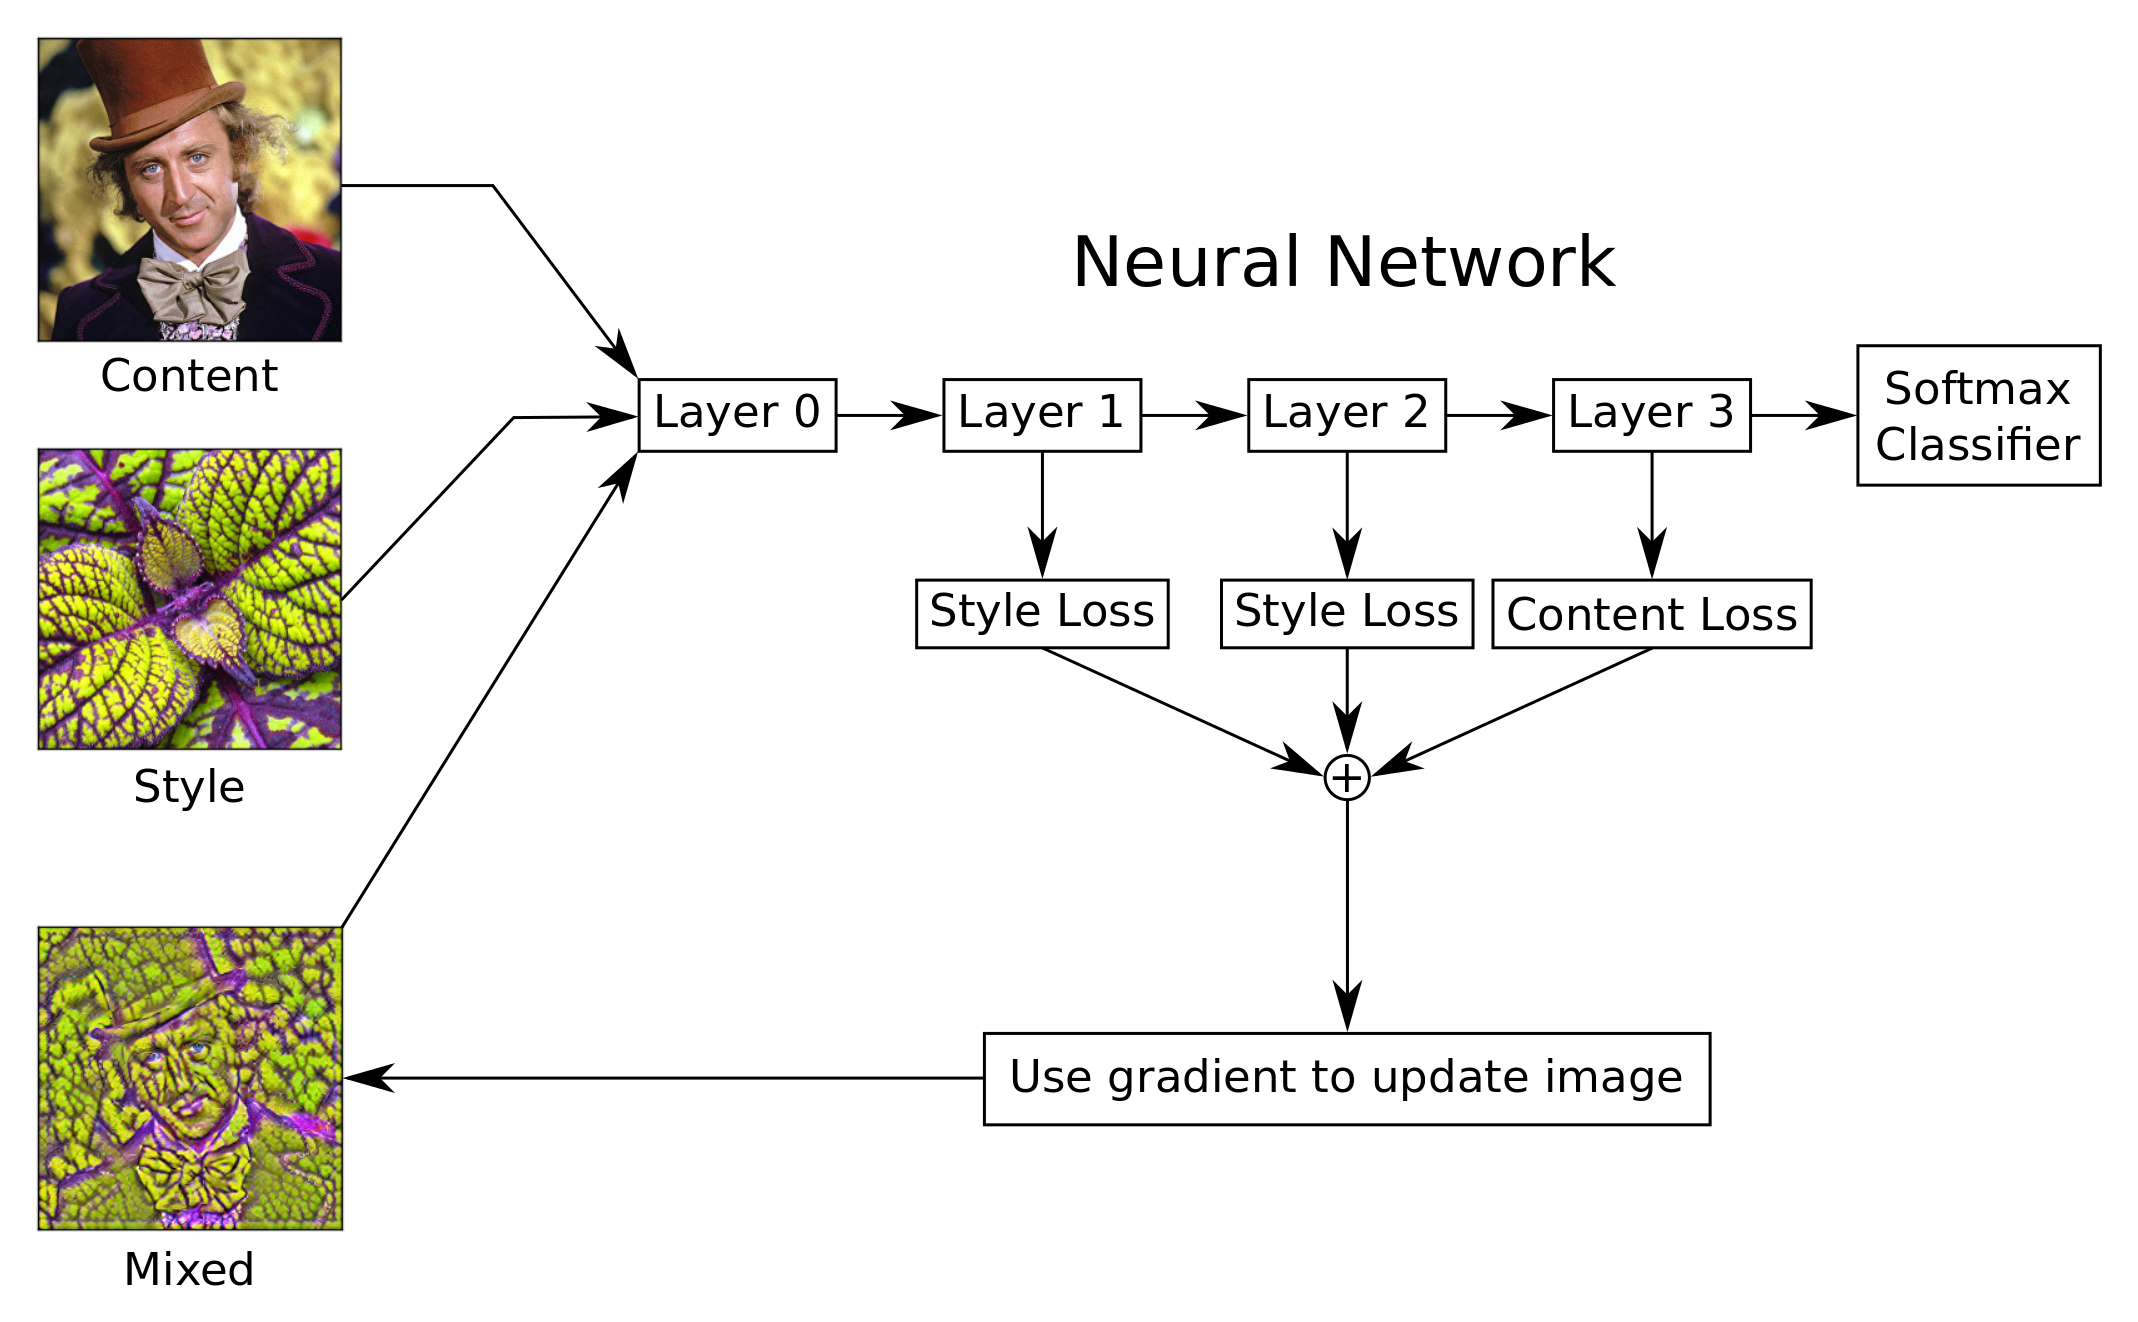

In [1]:
# from IPython.display import Image, display
# Image('images/style-transfer-flowchart.png')

# Imports

In [2]:
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

# VGG16 Model

The original paper on style transfer used the VGG-19 convolutional neural network. But the pre-trained VGG-19 models for TensorFlow did not seem suitable for this tutorial for different reasons. Instead we will use the VGG-16 model, which someone else has made available and which can easily be loaded in TensorFlow. We have wrapped it in a class for convenience.

In [3]:
import vgg16

Download the data for the VGG-16 model if it doesn't already exist in the directory.

In [4]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


# Image manipulation functions

This function loads an image and returns it as a numpy array of floating-points. The image can be automatically resized so the largest of the height or width equals max_size.

In [5]:
def load_image(filename, shape=None, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for ensuring a max height and width, while keeping the proportion
        # between them
        factor = float(max_size) / np.max(image.size)

        # Scale the image's height and width
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled, but PIL requires the size to be integers
        size = size.astype(int)

        # Resize the image
        image = image.resize(size, Image.LANCZOS)  # PIL.Image.LANCZOS is one of resampling filter

    if shape is not None:
        image = image.resize(shape, Image.LANCZOS)  # PIL.Image.LANCZOS is one of resampling filter

    # Convert to numpy floating-point array
    return np.float32(image)

This function saves an image as a jpeg file. The image is given as a numpy array with pixel-values between 0 and 255.

In [6]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255
    image = np.clip(image, 0.0, 255.0)

    # Convert to bytes
    image = image.astype(np.uint8)

    # Write the image-file in jpeg-format
    with open(filename, 'wb') as file:
        Image.fromarray(image).save(file, 'jpeg')

This function plots a large image. The image is given as a numpy array with pixel-values between 0 and 255.

In [7]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(Image.fromarray(image))

This function plots the content, style and mixed images.

In [8]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Plot the content-image. Note that the pixel-values are normalized to the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Content")

    # Plot the mixed-image
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Output")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Style")

    # Remove ticks from all the plots
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

# Loss Functions

These helper functions create the loss functions that are used in optimization with TensorFlow.

This function creates a TensorFlow operation for calculating the Mean Squared Error between the two input tensors.

In [9]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

This function creates the loss-function for the content-image. It is the Mean Squared Error of the feature activations in the given layers in the model, between the content-image and the mixed-image. When this content-loss is minimized, it therefore means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers you select, this should transfer the contours from the content-image to the mixed-image.

In [10]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add computational nodes to it. It is not always clear when this is
    #necessary in TensorFlow, but if you want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated for this layer in the model when inputting the content-image. Wrap it
            # to ensure it is a const - although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the Mean Squared Error between the layer-values when inputting the
            # content- and mixed-images. Note that the mixed-image is not calculated yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average. The loss-functions could be weighted differently for each
        # layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

We will do something similar for the style-layers, but now we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

One way of doing this, is to calculate the so-called Gram-matrix for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

This is the helper-function for calculating the Gram-matrix of a tensor output by a convolutional layer in the neural network. The actual loss-function is created further below.

In [11]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor, which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of the 2-dim matrix with itself. This calculates the dot-products of all
    # combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

The next function creates the loss-function for the style-image. It is quite similar to create_content_loss() above, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.

In [12]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add computational nodes to it. It is not always clear when this is
    # necessary in TensorFlow, but if you want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated for this layer in the model when inputting the style-image.
            # Wrap it to ensure it is a const, although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the Mean Squared Error between the Gram-matrix values for the content-
            # and mixed-images. Note that the mixed-image is not calculated yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average. The loss-functions could be weighted differently for each
        # layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called Total Variation Denoising and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [13]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

# Style-Transfer Algorithm
This is the main optimization algorithm for the Style-Transfer algorithm. It is basically just gradient descent on the loss-functions defined above.

This algorithm also uses normalization of the loss-functions. This appears to be a novel idea not previously published. In each iteration of the optimization, the loss-values are adjusted so each of them equals one. This allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

In [14]:
def style_transfer(content_image, style_image, content_layer_ids, style_layer_ids, weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3, num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

# Example
This example shows how to transfer the style of various images onto a portrait.

First we load the content-image which has the overall contours that we want in the mixed-image.

In [24]:
content_filename = 'content/willy_wonka_old.jpg'
content_image = load_image(content_filename, max_size=None)

Then we load the style-image which has the colours and textures we want in the mixed-image.

In [29]:
style_filename = 'style/style7.jpg'
style_image = load_image(style_filename, max_size=300)

Then we define a list of integers which identify the layers in the neural network that we want to use for matching the content-image. These are indices into the layers in the neural network. For the VGG16 model, the 5th layer (index 4) seems to work well as the sole content-layer.

In [30]:
content_layer_ids = [4]

Then we define another list of integers for the style-layers.

In [31]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

Now perform the style-transfer. This automatically creates the appropriate loss-functions for the style- and content-layers, and then performs a number of optimization iterations. This will gradually create a mixed-image which has similar contours as the content-image, with the colours and textures being similar to the style-image.

This can be very slow on a CPU!

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.18e-11, Style: 2.14e-29, Denoise: 5.61e-06


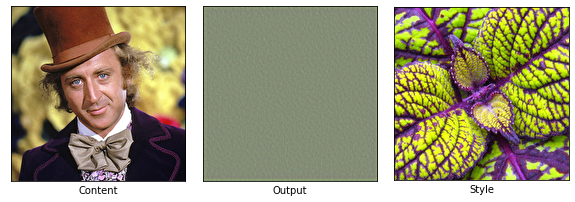

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 3.03e-11, Style: 3.75e-28, Denoise: 1.31e-07


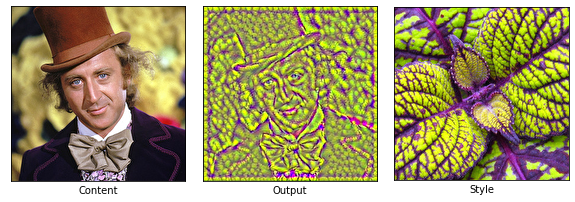

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 2.91e-11, Style: 5.50e-28, Denoise: 1.36e-07


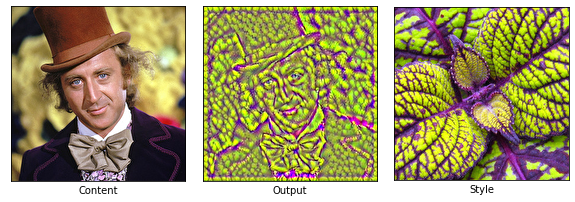

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 2.76e-11, Style: 8.15e-28, Denoise: 1.30e-07


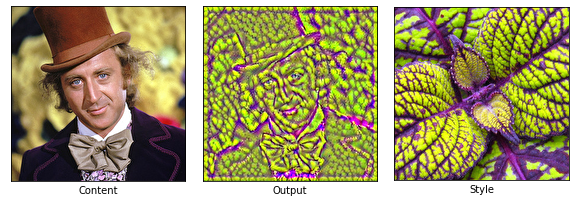

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 2.78e-11, Style: 8.48e-28, Denoise: 1.27e-07


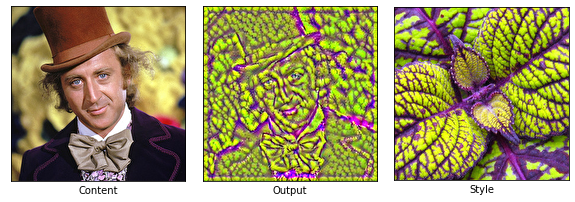

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 2.79e-11, Style: 8.48e-28, Denoise: 1.24e-07


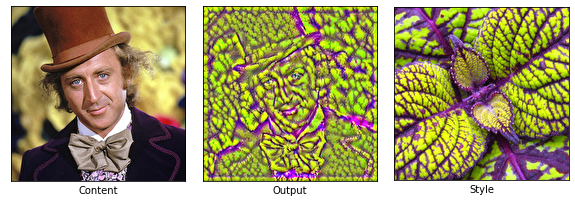

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 1.86e-11, Style: 4.31e-28, Denoise: 1.00e-07


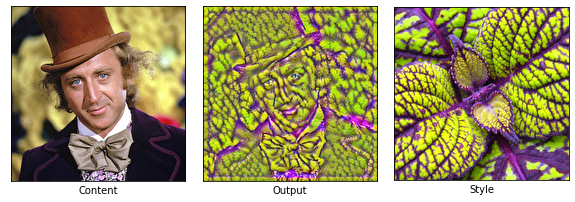


Final image:


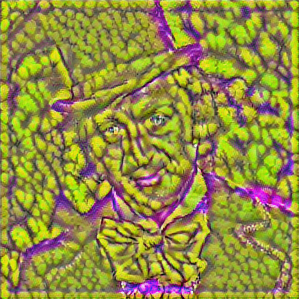

Wall time: 4min 36s


In [32]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

# Conclusion
This tutorial showed the basic idea of using neural networks for combining the content and style of two images. The results were unfortunately not as pretty as some of the systems that are commercially available, such as DeepArt which was developed by some of the pioneers in these techniques. The reason is unclear. Perhaps we simply need more computational power so we can perform more optimization iterations with smaller step-sizes and for higher-resolution images. Or perhaps we need to use a more sophisticated optimization method.